# Семинар 6. Основы работы с библиотеками scanpy и Seurat

Это практикум с анализом данных scRNA-Seq. Он основан на пакете scanpy для Python 3 и Seurat для R версии 4 и больше.

In [ ]:
# Загрузка R magic
!pip install rpy2==3.5.1

# Установка нужных пакетов
!apt-get install libgmp3-dev libcairo2-dev libharfbuzz-dev libfribidi-dev libudunits2-dev
!pip install --upgrade --no-cache-dir gdown
!gdown 1W0TuuQospxcasOX5cQdhT_Xd-k7-QAck
!tar xf library.tar.gz
!pip3 install scanpy[leiden] anndata2ri

# Необходимо, чтобы конкретно прогрузился matplotlib
import os
os.kill(os.getpid(), 9)

%load_ext rpy2.ipython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 201 kB 5.0 MB/s 
  Created wheel for rpy2: filename=rpy2-3.5.1-cp38-cp38-linux_x86_64.whl size=310199 sha256=d3a80ea21e69dbafa83711996439d24dadc7000f1653611970cd2d5bb466bd29
  Stored in directory: /root/.cache/pip/wheels/6b/40/7d/f63e87fd83e8b99ee837c8e3489081c4b3489134bc520235ed
Successfully built rpy2
  Attempting uninstall: rpy2
    Found existing installation: rpy2 3.5.5
    Uninstalling rpy2-3.5.5:
      Successfully uninstalled rpy2-3.5.5
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libharfbuzz-dev is already the newest version (1.7.2-1ubuntu1).
libharfbuzz-dev set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libcairo-script-int

In [1]:
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython
%R .libPaths("usr/local/lib/R/site-library/")

'/content/...,'/usr/loca...,'/usr/lib/...,'/usr/lib/...


Давайте для начала скачаем и распакуем архив с аутпутом программы Cell Ranger (без файла выравнивания, для уменьшения объёма). Он лежит в Google Colab со следующим ID: `1qmMBM0gt3EO9Gk30Weo11Sriy3wuZmUM` — и может быть загружен при помощи gdown:

In [2]:
!gdown 1Ctq4EmV2ps1dMiFcbqW467ywezRSGGN0
!unzip PBMC_10k.zip

Downloading...
From: https://drive.google.com/uc?id=1Ctq4EmV2ps1dMiFcbqW467ywezRSGGN0
To: /content/PBMC_10k.zip
100% 345M/345M [00:04<00:00, 75.9MB/s]
Archive:  PBMC_10k.zip
  inflating: filtered_feature_bc_matrix.h5  
  inflating: filtered_feature_bc_matrix.tar.gz  
  inflating: metrics_summary.csv     
  inflating: raw_feature_bc_matrix.h5  
  inflating: raw_feature_bc_matrix.tar.gz  
  inflating: web_summary.html        


Мы видим четыре файла: архив с нефильтрованной матрицей экспрессий, архив с отфильтрованными клетками, а также .html-отчёт о качестве выравнивания и его текстовая версия. Разархивируем отфильтрованные матрицы экспрессий.

In [3]:
!tar -xvzf filtered_feature_bc_matrix.tar.gz

filtered_feature_bc_matrix/
filtered_feature_bc_matrix/matrix.mtx.gz
filtered_feature_bc_matrix/features.tsv.gz
filtered_feature_bc_matrix/barcodes.tsv.gz


## Scanpy и AnnData

Давайте прочитаем содержимое отфильтрованной матрицы и создадим объект формата AnnData (и назовём его adata). Попробуем вывести его функцией `print()`.

In [4]:
import scanpy as sc

adata = sc.read_10x_mtx("filtered_feature_bc_matrix") # Эта функция позволяет быстро прочитать аутпут программы Cell Ranger
print(adata) # Выведем содержимое

AnnData object with n_obs × n_vars = 11996 × 36601
    var: 'gene_ids', 'feature_types'


Сердце объекта AnnData — это матрица, в которой находятся данные по числу UMI каждого гена на каждую клетку. В нашем случае эта матрица имеет размерность число клеток × число генов, то есть 8381 × 33694. Для того, чтобы напрямую обратиться к этой матрице, необходимо вызвать объект `adata.X`.

Эта матрица пока находится в sparse-виде. Это такой формат, который подразумевает, что нулей в матрице сильно больше, чем ненулевых элементов — тогда в явном виде можно хранить только координаты ненулевых элементов, это сильно экономит память. Ниже будет приведена иллюстрация того, как выглядит sparse-матрица.

In [5]:
from scipy.sparse import csr_matrix
import numpy as np

x = np.matrix(
    [[1, 0, 0, 0, 0],
     [0, 1, 0, 0, 0],
     [0, 0, 1, 0, 0],
     [0, 0, 0, 1, 0],
     [0, 0, 0, 0, 1]]
) # Создадим матрицу, с которой мы будем работать
print(x) # Выведем её содержимое

[[1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]]


In [6]:
x_csr = csr_matrix(x) # Создадим из матрицы x sparse-матрицу
print(x_csr) # Выведем её содержимое

  (0, 0)	1
  (1, 1)	1
  (2, 2)	1
  (3, 3)	1
  (4, 4)	1


In [7]:
x_csr.A

array([[1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1]])

Посмотрим на содержимое нашего scRNA-Seq датасета:

In [8]:
print(adata.X.A)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [14]:
print(adata.X)

  (0, 24)	1.0
  (0, 29)	5.0
  (0, 30)	18.0
  (0, 44)	2.0
  (0, 59)	3.0
  (0, 60)	2.0
  (0, 62)	1.0
  (0, 75)	1.0
  (0, 85)	1.0
  (0, 86)	3.0
  (0, 97)	2.0
  (0, 104)	1.0
  (0, 113)	1.0
  (0, 170)	16.0
  (0, 182)	1.0
  (0, 208)	2.0
  (0, 219)	4.0
  (0, 237)	1.0
  (0, 241)	1.0
  (0, 245)	1.0
  (0, 254)	1.0
  (0, 265)	1.0
  (0, 282)	1.0
  (0, 290)	1.0
  (0, 293)	1.0
  :	:
  (11995, 36368)	1.0
  (11995, 36372)	3.0
  (11995, 36378)	6.0
  (11995, 36383)	2.0
  (11995, 36390)	1.0
  (11995, 36398)	1.0
  (11995, 36401)	65.0
  (11995, 36407)	1.0
  (11995, 36413)	1.0
  (11995, 36422)	1.0
  (11995, 36432)	1.0
  (11995, 36433)	3.0
  (11995, 36559)	25.0
  (11995, 36560)	16.0
  (11995, 36561)	76.0
  (11995, 36562)	76.0
  (11995, 36563)	1.0
  (11995, 36564)	84.0
  (11995, 36565)	66.0
  (11995, 36566)	39.0
  (11995, 36567)	3.0
  (11995, 36568)	46.0
  (11995, 36569)	8.0
  (11995, 36570)	1.0
  (11995, 36571)	44.0


Теперь можем посмотреть, что хранится в датафрейме с аннотацией клеток (баркод).

In [9]:
adata.obs # Шапка датафрейма с аннотацией клеток

""
AAACCCAAGGCCCAAA-1
AAACCCAAGTAATACG-1
AAACCCAAGTCACACT-1
AAACCCACAAAGCGTG-1
AAACCCACAATCGAAA-1
...
TTTGTTGGTTGGATCT-1
TTTGTTGGTTTCTTAC-1
TTTGTTGTCCATTTCA-1
TTTGTTGTCTACACAG-1


Мы видим, что в аннотации по клеткам нет никаких дополнительных полей, кроме индекса с баркодами клеток. Какие это могут быть дополнительные поля? Например, сколько различных генов экспрессируется в клетке, из какого пациента были получены клетки, к какому типу клеток они относятся. Дальше этот датафрейм будет только расширяться, и к концу мы увидим, насколько много будет у него полей. Давайте попробуем добавить колонку tissue, которой присвоим значение PBMC.

In [10]:
adata.obs["tissue"] = "PBMC" # Делаем новый лист, который будет состоять из слова PBMC
adata.obs.head()

,tissue
AAACCCAAGGCCCAAA-1,PBMC
AAACCCAAGTAATACG-1,PBMC
AAACCCAAGTCACACT-1,PBMC
AAACCCACAAAGCGTG-1,PBMC
AAACCCACAATCGAAA-1,PBMC


Правилом хорошо тона будет переименовывание индекса в индекс, описывающий данные (например, donor1 или don2).

In [11]:
sample_name = "don1"
adata.obs.index = [barcode.split("-")[0] + f":{sample_name}" for barcode in adata.obs.index]

In [12]:
adata.obs.head()

,tissue
AAACCCAAGGCCCAAA:don1,PBMC
AAACCCAAGTAATACG:don1,PBMC
AAACCCAAGTCACACT:don1,PBMC
AAACCCACAAAGCGTG:don1,PBMC
AAACCCACAATCGAAA:don1,PBMC


Теперь посмотрим на датафрейм с аннотацией по генам.

In [13]:
adata.var.head() # Шапка датафрейма с аннотацией генов

,gene_ids,feature_types
MIR1302-2HG,ENSG00000243485,Gene Expression
FAM138A,ENSG00000237613,Gene Expression
OR4F5,ENSG00000186092,Gene Expression
AL627309.1,ENSG00000238009,Gene Expression
AL627309.3,ENSG00000239945,Gene Expression


Аннотация по генам содержит индекс в виде краткого говорящего названия гена, а также дополнительное поле — gene_id.

## Seurat

Теперь посмотрим, как аналогичные действия можно выполнить при помощи пакета Seurat.

In [13]:
%%R

library(Seurat)

expression_matrix <- Read10X(data.dir = "filtered_feature_bc_matrix")
seurat.obj <- CreateSeuratObject(counts = expression_matrix)
seurat.obj

NotImplementedError: ignored

Объект Seurat устроен чуть сложнее, чем anndata. Давайте посмотрим названия клеток из датасета:

Как же посмотреть описание клеток? Механика проста и похожа на то, что есть в scanpy:

In [16]:
%R seurat.obj[[]]

NotImplementedError: ignored

In [ ]:
%R seurat.obj$tissue <- "PBMC"
%R seurat.obj[[]]

,orig.ident,nCount_RNA,nFeature_RNA,tissue
AAACCCAAGGCCCAAA-1,SeuratProject,12143.0,3022,PBMC
AAACCCAAGTAATACG-1,SeuratProject,7811.0,2667,PBMC
AAACCCAAGTCACACT-1,SeuratProject,9741.0,2934,PBMC
AAACCCACAAAGCGTG-1,SeuratProject,5561.0,1525,PBMC
AAACCCACAATCGAAA-1,SeuratProject,7399.0,2078,PBMC
...,...,...,...,...
TTTGTTGGTTGGATCT-1,SeuratProject,6199.0,1602,PBMC
TTTGTTGGTTTCTTAC-1,SeuratProject,4658.0,1902,PBMC
TTTGTTGTCCATTTCA-1,SeuratProject,5059.0,1551,PBMC
TTTGTTGTCTACACAG-1,SeuratProject,5037.0,2194,PBMC


Теперь давайте выведем экспрессии генов <i>CD3D</i>, <i>TCL1A</i> и <i>MS4A1</i> у первых двадцати клеток в Seurat и scanpy:

In [ ]:
%%R
GetAssayData(object = seurat.obj[c("CD3D", "TCL1A", "MS4A1"), 1:20], slot = "counts")

3 x 20 sparse Matrix of class "dgCMatrix"
                                             
[1,] . . . 1 . . . 20 2 8 . . . 5 3 . . . . 5
[2,] . . . . . . .  . . . . . . . . . . . . .
[3,] . . . . 9 6 .  . . . . . . . . . . . . .


In [ ]:
print(adata[:20, ["CD3D", "TCL1A", "MS4A1"]].X.A.T)

[[ 0.  0.  0.  1.  0.  0.  0. 20.  2.  8.  0.  0.  0.  5.  3.  0.  0.  0.
   0.  5.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  9.  6.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]]


### Задание

Постройте диаграмму рассения, в которой по одной оси будет экспрессия гена <i>CD8A</i>, а на другой &mdash; экспрессия <i>CD4</i>.

<AxesSubplot:>

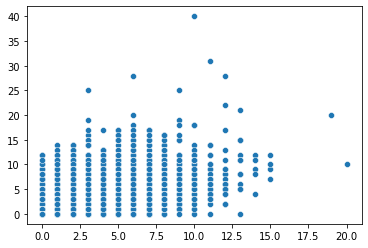

In [ ]:
import seaborn as sns
sns.scatterplot(x=adata[:, "CD3E"].X.A.T[0], y=adata[:, "CD3D"].X.A.T[0])

### Задание

Возьмите значения столбца `nCount_RNA` из Seurat-объекта и добавьте его в объект `adata`.

In [ ]:
%%R -o ncounts
ncounts <- seurat.obj[["nCount_RNA"]]

In [ ]:
ncounts.index = [bc.split("-")[0] + ":don1" for bc in ncounts.index]

In [ ]:
adata.obs["nCount_RNA"] = ncounts
adata.obs

,tissue,nCount_RNA
AAACCCAAGGCCCAAA:don1,PBMC,12143.0
AAACCCAAGTAATACG:don1,PBMC,7811.0
AAACCCAAGTCACACT:don1,PBMC,9741.0
AAACCCACAAAGCGTG:don1,PBMC,5561.0
AAACCCACAATCGAAA:don1,PBMC,7399.0
...,...,...
TTTGTTGGTTGGATCT:don1,PBMC,6199.0
TTTGTTGGTTTCTTAC:don1,PBMC,4658.0
TTTGTTGTCCATTTCA:don1,PBMC,5059.0
TTTGTTGTCTACACAG:don1,PBMC,5037.0


## SingleCellExperiment и anndata2ri

В дальнейшем удобно будет пользоваться тем, что существует пакет <code>anndata2ri</code>, который позволяет из окружения Python передать объект AnnData в окружение R, трансформировав его в объект класса SingleCellExperiment. В свою очередь объект класса SingleCellExperiment может быть легко трансформирован в Seurat.

In [1]:
%%R -i adata
adata

UsageError: Cell magic `%%R` not found.


In [ ]:
%%R
adata.to.seurat <- as.Seurat(adata, data = NULL, counts = "X")
adata.to.seurat

An object of class Seurat 
36601 features across 11996 samples within 1 assay 
Active assay: originalexp (36601 features, 0 variable features)


In [ ]:
%R adata.to.seurat[[]]

,orig.ident,nCount_originalexp,nFeature_originalexp,tissue,nCount_RNA
AAACCCAAGGCCCAAA:don1,SeuratProject,12143.0,3022,PBMC,12143.0
AAACCCAAGTAATACG:don1,SeuratProject,7811.0,2667,PBMC,7811.0
AAACCCAAGTCACACT:don1,SeuratProject,9741.0,2934,PBMC,9741.0
AAACCCACAAAGCGTG:don1,SeuratProject,5561.0,1525,PBMC,5561.0
AAACCCACAATCGAAA:don1,SeuratProject,7399.0,2078,PBMC,7399.0
...,...,...,...,...,...
TTTGTTGGTTGGATCT:don1,SeuratProject,6199.0,1602,PBMC,6199.0
TTTGTTGGTTTCTTAC:don1,SeuratProject,4658.0,1902,PBMC,4658.0
TTTGTTGTCCATTTCA:don1,SeuratProject,5059.0,1551,PBMC,5059.0
TTTGTTGTCTACACAG:don1,SeuratProject,5037.0,2194,PBMC,5037.0


### Задание

Попробуйте выбрать только те клетки, у которых в сумме больше, чем 10000 молекул, а также только те гены, которые экспрессируются более, чем в 3 клетках. Сделайте это как в Seurat, так и в scanpy, после чего обменяйте переменные в окружениях (например, <code>adata_filtered</code> переместите в окружение R и назовите его там <code>adata.to.Seurat.filtered</code>, и наоборот).

In [ ]:
adata = adata[:, (adata.X > 0).sum(axis=0).A[0] > 3]
adata = adata[adata.X.sum(axis=1) > 10000]
adata

View of AnnData object with n_obs × n_vars = 2944 × 21460
    var: 'gene_ids', 'feature_types'

In [ ]:
%%R
seurat.filtered <- seurat.obj[rowSums(GetAssayData(object = seurat.obj, slot = "counts") > 0) > 3,]
seurat.filtered <- seurat.filtered[,colSums(GetAssayData(object = seurat.filtered, slot = "counts")) > 10000]
seurat.filtered

An object of class Seurat 
21460 features across 2944 samples within 1 assay 
Active assay: RNA (21460 features, 0 variable features)


In [ ]:
%%R -o sce
sce <- as.SingleCellExperiment(seurat.filtered)

/usr/local/lib/python3.7/dist-packages/anndata2ri/r2py.py:106: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)


## Домашнее задание

Сделайте несколько вспомогательных функций, которые вам позднее пригодятся:
1. Разбиение одного объекта AnnData на список других, соответствующих каждому индивидуальному батчу;
2. Создание нового объекта со случайными N клетками и M генами из изначального;
3. Сохранение вашего AnnData-объекта как Seurat-объекта в формате `.rds`.

{'1': Ellipsis}

View of AnnData object with n_obs × n_vars = 2944 × 21460
    var: 'gene_ids', 'feature_types'